# Installing Dependencies

In [ ]:
# Install TorchDistill (PyTorch-based KD framework)
%pip install torchdistill

# Install PyTorch and dependencies
%pip install torch torchvision

# Install Hugging Face Transformers for model loading
%pip install transformers

# Install dataset tools
%pip install datasets
# for image Processiing
%pip install opencv-python

%pip install matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from transformers import pipeline
from transformers import AutoModelForDepthEstimation
import PIL
from PIL import Image
import requests
import cv2
import numpy as np
import os






print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)
# print("TorchDistill version:", torchdistill.__version__)

PyTorch version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124


# Loading the Models

In [4]:
# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to("cuda")

# Load student model
student = AutoModelForDepthEstimation.from_pretrained("xingyang1/Distill-Any-Depth-Small-hf").to("cuda")

# Enable gradient checkpointing for teacher and student
teacher.gradient_checkpointing_enable()
student.gradient_checkpointing_enable()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
class DepthAnythingV2Teacher(nn.Module):
    def __init__(self, mod):
        super().__init__()
        self.model = mod;
        self.eval()

    def forward(self, x):
        self.model(x)
        return self.model(x).predicted_depth


In [7]:
class DistillAnyDepthStudent(nn.Module):
    def __init__(self, mod):
        super().__init__()
        self.model = mod


    def forward(self, x):
      return self.model(x).predicted_depth


# Loading Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os

class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB') # Ensure RGB

        if self.transform:
            image = self.transform(image)
        return image

# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=5, shuffle=True, num_workers=2)

print(f"Number of batches in data loader: {len(unlabeled_dataloader)}")

Found 48 images in /content/drive/MyDrive/images/
Number of batches in data loader: 10


#Define Distillaion Loss

In [9]:
class DepthDistillationLoss(nn.Module):
    def __init__(self, lambda_depth=1.0, lambda_features=0.0):
        super().__init__()
        self.lambda_depth = lambda_depth
        self.lambda_features = lambda_features
        self.mae_loss = nn.L1Loss() # Mean Absolute Error for depth maps
        self.mse_loss = nn.MSELoss() # Mean Squared Error for features

    def forward(self, student_outputs, teacher_outputs):
        # student_outputs and teacher_outputs can be tuples (depth_map, [features])
        student_depth = student_outputs[0] if isinstance(student_outputs, tuple) else student_outputs
        teacher_depth = teacher_outputs[0] if isinstance(teacher_outputs, tuple) else teacher_outputs

        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. Depth Map Loss (MAE)
        if self.lambda_depth > 0:
            loss_depth = self.mae_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Feature Loss (MSE) - if features are provided
        if self.lambda_features > 0 and isinstance(student_outputs, tuple) and isinstance(teacher_outputs, tuple):
            student_features = student_outputs[1]
            teacher_features = teacher_outputs[1]
            if len(student_features) != len(teacher_features):
                raise ValueError("Number of student and teacher feature lists must match.")

            loss_features = 0.0
            for sf, tf in zip(student_features, teacher_features):
                # Ensure feature maps are of compatible sizes if different layers have different resolutions
                # You might need to interpolate sf to tf.size() or vice-versa
                if sf.shape != tf.shape:
                    # Example: Interpolate student feature to teacher feature size
                    sf = F.interpolate(sf, size=tf.shape[2:], mode='bilinear', align_corners=False)
                loss_features += self.mse_loss(sf, tf)

            total_loss += self.lambda_features * (loss_features / len(student_features)) # Average feature loss

        return total_loss

# Instantiate the custom loss function

distillation_criterion = DepthDistillationLoss(lambda_depth=1.0, lambda_features=0.0)

# Training Loop

In [20]:
import torch.optim as optim
import time

def train_knowledge_distillation(teacher, student, dataloader, criterion, optimizer, epochs, device):
    teacher.eval() # Teacher should always be in evaluation mode
    student.train() # Student in training mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    models = []
    x = 0
    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, inputs in enumerate(dataloader):
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(inputs) # Returns depth map and/or features

            # Forward pass with Student model
            student_outputs = student(inputs) # Returns depth map and/or features

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)

            # Backpropagation and Optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss / (batch_idx+1):.4f}")

        epoch_loss = running_loss / len(dataloader)
        end_time = time.time()
        print(f"Epoch {epoch+1} finished. Avg Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")

        # Save student model checkpoint periodically
        if(epoch+1)%5 == 0:
          models.append(student)
          # torch.save(student.state_dict(), f"/content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")
          # print(f"Student model saved to /content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")

    print("Knowledge Distillation Training Finished!")
    return models


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

    # Instantiate Teacher and Student models
    # Make sure to set features_to_extract if you're using feature-based distillation
teacher_feature_layers = [0, 2] # Example: Extract features after first conv and first relu
student_feature_layers = [0, 2] # Example: Extract features after first conv and first relu

    # Ensure you load the actual DepthAnythingV2 Large here
    # For now, using dummy models
teacher_model = DepthAnythingV2Teacher(teacher).to(device)
student_model = DistillAnyDepthStudent(student).to(device)

    # Initialize optimizer for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

    # Training parameters
num_epochs = 5

    # Run the training
mods = train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    dataloader=unlabeled_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")

Using device: cuda
Starting Knowledge Distillation Training on cuda...
Epoch 1 finished. Avg Loss: 92.8049, Time: 21.02s
Epoch 2 finished. Avg Loss: 83.9285, Time: 21.56s
Epoch 3 finished. Avg Loss: 78.6386, Time: 21.20s
Epoch 4 finished. Avg Loss: 75.5112, Time: 21.08s
Epoch 5 finished. Avg Loss: 74.0122, Time: 21.13s
Knowledge Distillation Training Finished!
Training complete. Student model saved at specified checkpoints.


# Rev

In [13]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(size=(384, 384)),  # Common depth model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = transform(Image.fromarray(image)).unsqueeze(0).to("cuda")

In [14]:
# Set models to evaluation mode
teacher.eval()
student.eval()

with torch.no_grad():
    # Student prediction
    student_depth_before= student(input_tensor).predicted_depth
    print(student_depth_before.shape)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    print(student_depth_before_training.shape)

torch.Size([1, 378, 378])
(378, 378)


In [23]:
# Set models to evaluation mode
teacher.eval()
mods[0].eval()
# mods[1].eval()

with torch.no_grad():
    # Student prediction
    student_depth_after_5 = mods[0](input_tensor)
    print(student_depth_after_5.shape)
    student_depth_after_training_5 = student_depth_after_5.squeeze().cpu().numpy()
    print(student_depth_after_5.shape)

    # # Student prediction
    # student_depth_after_10 = mods[0](input_tensor).predicted_depth
    # print(student_depth_after_10.shape)
    # student_depth_after_training_10 = student_depth_after_10.squeeze().cpu().numpy()
    # print(student_depth_after_10.shape)

torch.Size([1, 378, 378])
torch.Size([1, 378, 378])


In [ ]:
def scale_shift_invariant_loss(student_depth, teacher_depth):
    """
    Computes the scale-and-shift invariantt loss between student and teacher depth maps.
    """
    B, H, W = student_depth.shape
    student = student_depth.view(B, -1)  # (B, H*W)
    teacher = teacher_depth.view(B, -1)

    # Create design matrix A = [student_values, 1]
    ones = torch.ones_like(student)  # (B, H*W)
    A = torch.stack([student, ones], dim=2)  # (B, H*W, 2)

    # Solve for optimal alpha (scale) and beta (shift)
    solution = torch.linalg.lstsq(A, teacher.unsqueeze(2)).solution  # (B, 2, 1)
    alpha = solution[:, 0, 0].view(B, 1, 1)
    beta = solution[:, 1, 0].view(B, 1, 1)

    # Align student depth and compute L1 loss
    aligned_student = alpha * student_depth + beta
    loss = torch.mean(torch.abs(aligned_student - teacher_depth))
    return loss

In [ ]:
def gradient_matching_loss(student_depth, teacher_depth):
    # Horizontal gradients
    student_grad_x = torch.abs(student_depth[:, :, 1:] - student_depth[:, :, :-1])
    teacher_grad_x = torch.abs(teacher_depth[:, :, 1:] - teacher_depth[:, :, :-1])

    # Vertical gradients
    student_grad_y = torch.abs(student_depth[:, 1:, :] - student_depth[:, :-1, :])
    teacher_grad_y = torch.abs(teacher_depth[:, 1:, :] - teacher_depth[:, :-1, :])

    # Use mean instead of sum to normalize by spatial dimensions
    loss_x = torch.mean(torch.abs(student_grad_x - teacher_grad_x))
    loss_y = torch.mean(torch.abs(student_grad_y - teacher_grad_y))
    return loss_x + loss_y

In [ ]:

temperature = 4.0
# Define loss weights
beta_ssi = 0.5       # Weight for scale-and-shift loss
gamma_gm = 0.5       # Weight for gradient matching loss


In [16]:
# Set models to evaluation mode
teacher.eval()
student.eval()
# model_epoch5.eval()


with torch.no_grad():
    # Teacher prediction
    teacher_depth = teacher(input_tensor).predicted_depth.squeeze().cpu().numpy()

    # Student prediction
    student_depth = student(input_tensor).predicted_depth.squeeze().cpu().numpy()


    # model_epoch5_depth = model_epoch5(input_tensor).predicted_depth.squeeze().cpu().numpy()

# Before Training

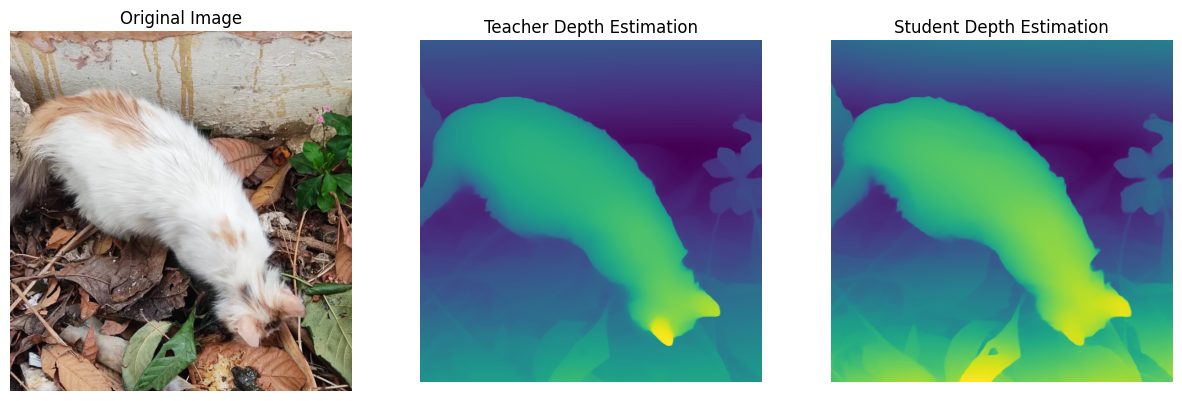

In [17]:
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation")
plt.axis("off")

plt.show()

# After Training

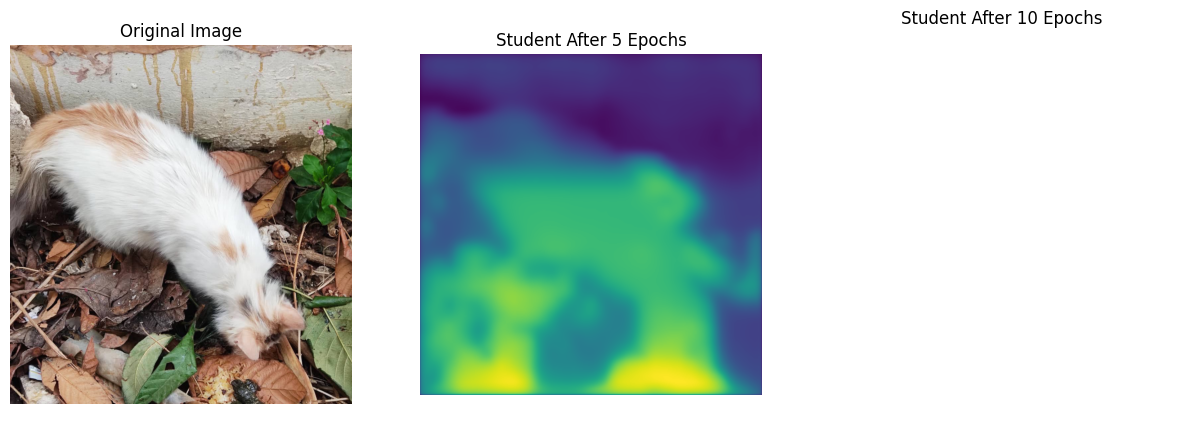

In [24]:
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(student_depth_after_training_5, cmap="viridis")
plt.title("Student After 5 Epochs")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
# plt.imshow(student_depth_after_training_10, cmap="viridis")
plt.title("Student After 10 Epochs")
plt.axis("off")

plt.show()

# Temp

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from transformers import pipeline
from transformers import AutoModelForDepthEstimation
# import torchdistill
import PIL
from PIL import Image
import requests
import cv2
import numpy as np
import os
import time

class DepthAnythingV2Teacher(nn.Module):
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        self.eval()
        # Assuming the model has a way to access intermediate features
        # This will need to be adapted based on the actual model architecture
        self.intermediate_features = {}
        def get_features(name):
            def hook(model, input, output):
                self.intermediate_features[name] = output
            return hook

        # Register hooks to capture features from specific layers
        # This is a placeholder and needs to be adjusted based on the actual model's layer names
        # For example, if you want features from the first and last convolutional layers:
        # self.model.encoder.layer[0].register_forward_hook(get_features('layer1'))
        # self.model.encoder.layer[-1].register_forward_hook(get_features('layer_last'))

    def forward(self, x):
        self.intermediate_features = {} # Clear features from previous forward pass
        depth_output = self.model(x).predicted_depth
        # Return depth and any captured features
        return depth_output, self.intermediate_features

class DistillAnyDepthStudent(nn.Module):
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        # Assuming the model has a way to access intermediate features
        # This will need to be adapted based on the actual model architecture
        self.intermediate_features = {}
        def get_features(name):
            def hook(model, input, output):
                self.intermediate_features[name] = output
            return hook

        # Register hooks to capture features from specific layers
        # This is a placeholder and needs to be adjusted based on the actual model's layer names
        # For example, if you want features from the first and last convolutional layers:
        # self.model.encoder.layer[0].register_forward_hook(get_features('layer1'))
        # self.model.encoder.layer[-1].register_forward_hook(get_features('layer_last'))


    def forward(self, x):
        self.intermediate_features = {} # Clear features from previous forward pass
        depth_output = self.model(x).predicted_depth
        # Return depth and any captured features
        return depth_output, self.intermediate_features

class DepthDistillationLoss(nn.Module):
    def __init__(self, lambda_depth=1.0, lambda_features=0.0, lambda_attention=0.0, lambda_relational=0.0):
        super().__init__()
        self.lambda_depth = lambda_depth
        self.lambda_features = lambda_features
        self.lambda_attention = lambda_attention
        self.lambda_relational = lambda_relational

        self.mae_loss = nn.L1Loss() # Mean Absolute Error for depth maps
        self.mse_loss = nn.MSELoss() # Mean Squared Error for features and attention
        self.kl_loss = nn.KLDivLoss(reduction="batchmean") # KL Divergence for relational knowledge

    def forward(self, student_outputs, teacher_outputs):
        # student_outputs and teacher_outputs are tuples: (depth_map, intermediate_features)
        student_depth, student_features = student_outputs
        teacher_depth, teacher_features = teacher_outputs

        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. Depth Map Loss (MAE)
        if self.lambda_depth > 0:
            loss_depth = self.mae_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Feature Loss (MSE)
        if self.lambda_features > 0:
            loss_features = 0.0
            # Assuming feature dictionaries have the same keys for corresponding layers
            for key in teacher_features.keys():
                if key in student_features:
                    sf = student_features[key]
                    tf = teacher_features[key]
                    # Ensure feature maps are of compatible sizes if different layers have different resolutions
                    if sf.shape != tf.shape:
                        # Example: Interpolate student feature to teacher feature size
                        sf = F.interpolate(sf, size=tf.shape[2:], mode='bilinear', align_corners=False)
                    loss_features += self.mse_loss(sf, tf)
            if len(teacher_features) > 0:
                total_loss += self.lambda_features * (loss_features / len(teacher_features))

        # 3. Attention Map Matching (Placeholder - requires access to attention weights)
        if self.lambda_attention > 0:
             # This part needs specific implementation based on how attention maps are accessed
             # For now, it's a placeholder
             pass

        # 4. Relational Knowledge Distillation (Placeholder - requires defining relationships)
        if self.lambda_relational > 0:
            # This part needs specific implementation based on how relational knowledge is defined
            # For now, it's a placeholder
            pass

        return total_loss

# Instantiate the custom loss function with feature matching enabled
distillation_criterion = DepthDistillationLoss(lambda_depth=1.0, lambda_features=0.5)

def train_knowledge_distillation(teacher, student, dataloader, criterion, optimizer, epochs, device):
    teacher.eval() # Teacher should always be in evaluation mode
    student.train() # Student in training mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    models = []
    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, inputs in enumerate(dataloader):
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(inputs) # Returns depth map and intermediate_features

            # Forward pass with Student model
            student_outputs = student(inputs) # Returns depth map and intermediate_features

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)

            # Backpropagation and Optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 10 == 0: # Reduced print frequency for clarity
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss / (batch_idx+1):.4f}")

        epoch_loss = running_loss / len(dataloader)
        end_time = time.time()
        print(f"Epoch {epoch+1} finished. Avg Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")

        # Save student model checkpoint periodically
        if(epoch+1)%5 == 0:
          models.append(student)

    print("Knowledge Distillation Training Finished!")
    return models

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
input_size = (384, 384)
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=5, shuffle=True, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate Teacher and Student models (using the previously loaded models)
teacher_model = DepthAnythingV2Teacher(teacher).to(device)
student_model = DistillAnyDepthStudent(student).to(device)

# Initialize optimizer for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 5

# Run the training
mods = train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    dataloader=unlabeled_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")